In [1]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
#from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms

from PIL import Image
from IPython.display import Image 



In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [3]:
batch_size = 10

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [4]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [6]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 10 images because batch_size=10 for the dataloaders
inputs, labels = next(iter(train_loader_MSE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


NameError: name 'train_loader_MSE' is not defined

In [7]:
batch_size = 10

In [8]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)


In [9]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")
train_loader_CE = torch.utils.data.DataLoader(dsetCE, shuffle=True, batch_size=batch_size)
dsetCE.__len__()

150

In [10]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

In [11]:
# Cellular automata class
class CAModel(nn.Module):

    def __init__(self, channel_n, fire_rate=0.5, device=torch.device("cpu")):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n
        self.fire_rate = fire_rate
        self.to(self.device)
        
        # Neural network model
        self.conv1 = nn.Conv2d(45, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv1a = nn.Conv2d(32, 24, kernel_size=1, padding=0)
        self.conv2 = nn.Conv2d(24, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 6, kernel_size=1)
        
        # Pre-defined weights for embedding information
        self.prewitt_x = torch.FloatTensor([[1,0,-1],[1,0,-1],[1,0,-1]]).to(dev)
        self.prewitt_y = torch.FloatTensor([[1,1,1],[0,0,0],[-1,-1,-1]]).to(dev)
        
        self.sobel_x = torch.FloatTensor([[1,0,-1],[2,0,-2],[1,0,-1]]).to(dev)
        self.sobel_y = torch.FloatTensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(dev)
        
        # If you want learnable weights
        # self.pre_weight = nn.Conv2d(9,27,kernel_size=3, padding=1)
        
    def perceive(self, x):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 Sobel and Prewitt operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalisation of these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)
                
        # Concatenate
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y
    
    
    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach()[:,3:9,:])
                
                b = self.perceive(x)
                bb = self.conv3(self.conv2(self.relu(self.conv1a(self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                #stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                #stochastic = stochastic.float().to(self.device)

                #d = bb*stochastic
                d = bb
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b = self.perceive(x)
                bb = self.conv3(self.conv2((self.conv1a(self.relu(self.conv1(b))))))
                
                c = x.detach().clone()
                #stochastic = torch.rand([bb.size(0),bb.size(1),bb.size(2),bb.size(3)])<self.fire_rate
                #stochastic = stochastic.float().to(self.device)

                #d = bb*stochastic
                d = bb
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [12]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.00036, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([2,1, 1.05, 8.4, 9, 8.1]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=w, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
loss_mse = []
loss_ce = []
history = []
epochs = 200

batch_size=10

In [12]:
# Only needed for collaborative automata
mask1 = torch.zeros(1,6,px_size,px_size).to(dev)
mask2 = torch.zeros(1,6,px_size,px_size).to(dev)
k = mask1.shape[2]
for i in range(k):
    for j in range(k):
        mask1[:,:,i,j] = (i + j + 1) % 2
        mask2[:,:,i,j] = (i + j) % 2

In [ ]:
# MSE training loop
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

In [25]:
from array2gif import write_gif
eh = [(max_rgb(epoch_history[i])[1]*255).cpu().detach().numpy() for i in range(len(epoch_history))]
#eh = [(max_rgb(epoch_history[i][0])*255).cpu().detach().numpy() for i in range(len(epoch_history))]

write_gif(eh, 'final.gif', fps=1)
#eh[0].shape
#torch.stack(epoch_history)[0].shape

Loss = tensor(1.8029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


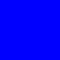

Learning rate:  0.00036
Loss = tensor(1.8030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


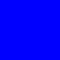

Learning rate:  0.00036
Loss = tensor(1.8014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


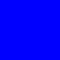

Learning rate:  0.00036
Loss = tensor(1.8005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.8008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


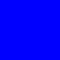

Learning rate:  0.00036
Loss = tensor(1.7987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


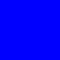

Learning rate:  0.00036
Loss = tensor(1.7975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7974, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


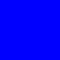

Learning rate:  0.00036
Loss = tensor(1.7967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


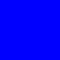

Learning rate:  0.00036
Loss = tensor(1.7951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


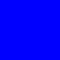

Learning rate:  0.00036
Loss = tensor(1.7929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


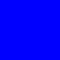

Learning rate:  0.00036
Loss = tensor(1.7894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


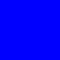

Learning rate:  0.00036
Loss = tensor(1.7898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


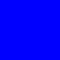

Learning rate:  0.00036
Loss = tensor(1.7862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


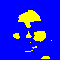

Learning rate:  0.00036
Loss = tensor(1.7819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


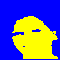

Learning rate:  0.00036
Loss = tensor(1.7805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


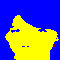

Learning rate:  0.00036
Loss = tensor(1.7722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


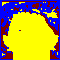

Learning rate:  0.00036
Loss = tensor(1.7635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


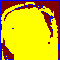

Learning rate:  0.00036
Loss = tensor(1.7581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


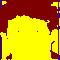

Learning rate:  0.00036
Loss = tensor(1.7546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


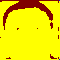

Learning rate:  0.00036
Loss = tensor(1.7279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


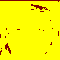

Learning rate:  0.00036
Loss = tensor(1.7206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


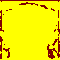

Learning rate:  0.00036
Loss = tensor(1.7037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


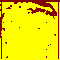

Learning rate:  0.00036
Loss = tensor(1.6703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


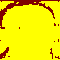

Learning rate:  0.00036
Loss = tensor(1.6660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


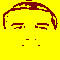

Learning rate:  0.00036
Loss = tensor(1.6506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


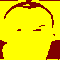

Learning rate:  0.00036
Loss = tensor(1.6254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


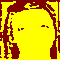

Learning rate:  0.00036
Loss = tensor(1.6246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


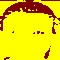

Learning rate:  0.00036
Loss = tensor(1.6027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


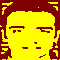

Learning rate:  0.00036
Loss = tensor(1.6025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


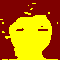

Learning rate:  0.00036
Loss = tensor(1.5895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


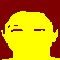

Learning rate:  0.00036
Loss = tensor(1.5731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5886, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


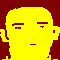

Learning rate:  0.00036
Loss = tensor(1.5736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5600, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


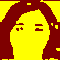

Learning rate:  0.00036
Loss = tensor(1.5884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


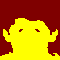

Learning rate:  0.00036
Loss = tensor(1.5413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


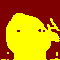

Learning rate:  0.00036
Loss = tensor(1.5469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


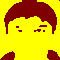

Learning rate:  0.00036
Loss = tensor(1.5518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5568, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


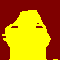

Learning rate:  0.00036
Loss = tensor(1.5341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


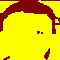

Learning rate:  0.00036
Loss = tensor(1.5437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


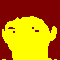

Learning rate:  0.00036
Loss = tensor(1.5449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


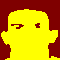

Learning rate:  0.00036
Loss = tensor(1.5229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


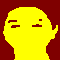

Learning rate:  0.00036
Loss = tensor(1.5655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


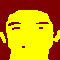

Learning rate:  0.00036
Loss = tensor(1.5604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


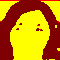

Learning rate:  0.00036
Loss = tensor(1.5380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


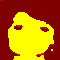

Learning rate:  0.00036
Loss = tensor(1.5419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


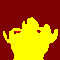

Learning rate:  0.00036
Loss = tensor(1.5452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


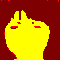

Learning rate:  0.00036
Loss = tensor(1.5303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


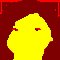

Learning rate:  0.00036
Loss = tensor(1.5123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


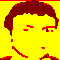

Learning rate:  0.00036
Loss = tensor(1.5229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


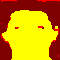

Learning rate:  0.00036
Loss = tensor(1.5075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


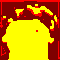

Learning rate:  0.00036
Loss = tensor(1.5010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


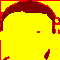

Learning rate:  0.00036
Loss = tensor(1.5343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


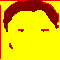

Learning rate:  0.00036
Loss = tensor(1.5122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


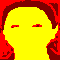

Learning rate:  0.00036
Loss = tensor(1.5420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


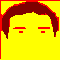

Learning rate:  0.00036
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


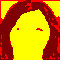

Learning rate:  0.00036
Loss = tensor(1.5120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


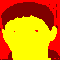

Learning rate:  0.00036
Loss = tensor(1.4853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


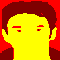

Learning rate:  0.00036
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


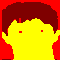

Learning rate:  0.00036
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


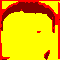

Learning rate:  0.00036
Loss = tensor(1.4489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


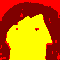

Learning rate:  0.00036
Loss = tensor(1.4572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


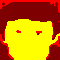

Learning rate:  0.00036
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


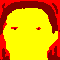

Learning rate:  0.00036
Loss = tensor(1.4999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


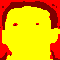

Learning rate:  0.00036
Loss = tensor(1.4359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


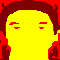

Learning rate:  0.00036
Loss = tensor(1.4382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


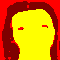

Learning rate:  0.00036
Loss = tensor(1.4134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


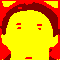

Learning rate:  0.00036
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


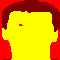

Learning rate:  0.00036
Loss = tensor(1.4121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


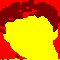

Learning rate:  0.00036
Loss = tensor(1.3858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


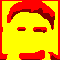

Learning rate:  0.00036
Loss = tensor(1.3762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


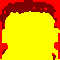

Learning rate:  0.00036
Loss = tensor(1.4279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


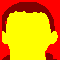

Learning rate:  0.00036
Loss = tensor(1.3795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


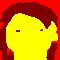

Learning rate:  0.00036
Loss = tensor(1.3902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


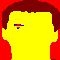

Learning rate:  0.00036
Loss = tensor(1.4240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


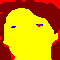

Learning rate:  0.00036
Loss = tensor(1.4412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


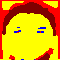

Learning rate:  0.00036
Loss = tensor(1.3831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


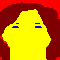

Learning rate:  0.00036
Loss = tensor(1.3707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


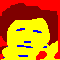

Learning rate:  0.00036
Loss = tensor(1.4019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


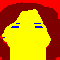

Learning rate:  0.00036
Loss = tensor(1.3841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


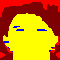

Learning rate:  0.00036
Loss = tensor(1.3798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


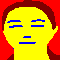

Learning rate:  0.00036
Loss = tensor(1.3844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


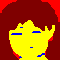

Learning rate:  0.00036
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


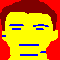

Learning rate:  0.00036
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


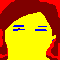

Learning rate:  0.00036
Loss = tensor(1.4112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


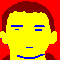

Learning rate:  0.00036
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


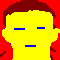

Learning rate:  0.00036
Loss = tensor(1.4133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


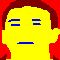

Learning rate:  0.00036
Loss = tensor(1.3748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


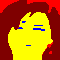

Learning rate:  0.00036
Loss = tensor(1.3843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


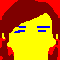

Learning rate:  0.00036
Loss = tensor(1.3460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


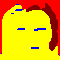

Learning rate:  0.00036
Loss = tensor(1.3976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


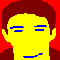

Learning rate:  0.00036
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


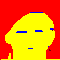

Learning rate:  0.00036
Loss = tensor(1.3671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


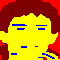

Learning rate:  0.00036
Loss = tensor(1.3359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


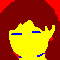

Learning rate:  0.00021600000000000002
Loss = tensor(1.3677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


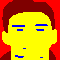

Learning rate:  0.00021600000000000002
Loss = tensor(1.3650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


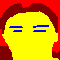

Learning rate:  0.00021600000000000002
Loss = tensor(1.3759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3578, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


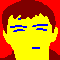

Learning rate:  0.00021600000000000002
Loss = tensor(1.3500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


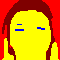

Learning rate:  0.00021600000000000002
Loss = tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


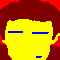

Learning rate:  0.00021600000000000002
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


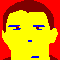

Learning rate:  0.00021600000000000002
Loss = tensor(1.3300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


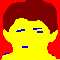

Learning rate:  0.00021600000000000002
Loss = tensor(1.3699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


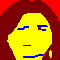

Learning rate:  0.00021600000000000002
Loss = tensor(1.3646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


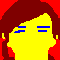

Learning rate:  0.00021600000000000002
Loss = tensor(1.3964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


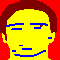

Learning rate:  0.00021600000000000002
Loss = tensor(1.3473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


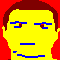

Learning rate:  0.00021600000000000002
Loss = tensor(1.3493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


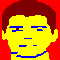

Learning rate:  0.00021600000000000002
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


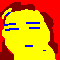

Learning rate:  0.00021600000000000002
Loss = tensor(1.3618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


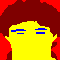

Learning rate:  0.00021600000000000002
Loss = tensor(1.3534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


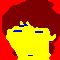

Learning rate:  0.00021600000000000002
Loss = tensor(1.3450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


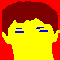

Learning rate:  0.00021600000000000002
Loss = tensor(1.3330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


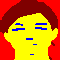

Learning rate:  0.00021600000000000002
Loss = tensor(1.3414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


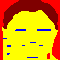

Learning rate:  0.00021600000000000002
Loss = tensor(1.3867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


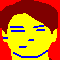

Learning rate:  0.00021600000000000002
Loss = tensor(1.3554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


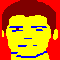

Learning rate:  0.00021600000000000002
Loss = tensor(1.4002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


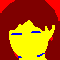

Learning rate:  0.00021600000000000002
Loss = tensor(1.3881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


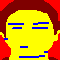

Learning rate:  0.00021600000000000002
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


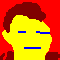

Learning rate:  0.00021600000000000002
Loss = tensor(1.3863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


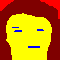

Learning rate:  0.00021600000000000002
Loss = tensor(1.3665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


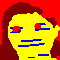

Learning rate:  0.00021600000000000002
Loss = tensor(1.3629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3655, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


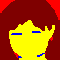

Learning rate:  0.00021600000000000002
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


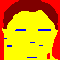

Learning rate:  0.00021600000000000002
Loss = tensor(1.3640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


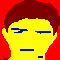

Learning rate:  0.00021600000000000002
Loss = tensor(1.3690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


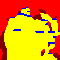

Learning rate:  0.00021600000000000002
Loss = tensor(1.3562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


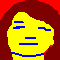

Learning rate:  0.00021600000000000002
Loss = tensor(1.3420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3592, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


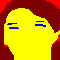

Learning rate:  0.00021600000000000002
Loss = tensor(1.4004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


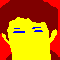

Learning rate:  0.00021600000000000002
Loss = tensor(1.3522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


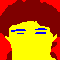

Learning rate:  0.00021600000000000002
Loss = tensor(1.3562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


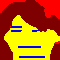

Learning rate:  0.00021600000000000002
Loss = tensor(1.3175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


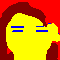

Learning rate:  0.00021600000000000002
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


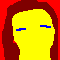

Learning rate:  0.00021600000000000002
Loss = tensor(1.3784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


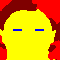

Learning rate:  0.00021600000000000002
Loss = tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3492, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


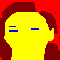

Learning rate:  0.00021600000000000002
Loss = tensor(1.3789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


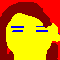

Learning rate:  0.00021600000000000002
Loss = tensor(1.3529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3430, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


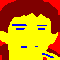

Learning rate:  0.00021600000000000002
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


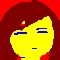

Learning rate:  0.00021600000000000002
Loss = tensor(1.3742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


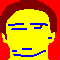

Learning rate:  0.00021600000000000002
Loss = tensor(1.3502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


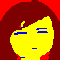

Learning rate:  0.00021600000000000002
Loss = tensor(1.3431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


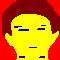

Learning rate:  0.00021600000000000002
Loss = tensor(1.3989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


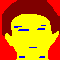

Learning rate:  0.00021600000000000002
Loss = tensor(1.3533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


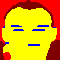

Learning rate:  0.00021600000000000002
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


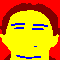

Learning rate:  0.00021600000000000002
Loss = tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


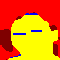

Learning rate:  0.00021600000000000002
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


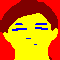

Learning rate:  0.00021600000000000002
Loss = tensor(1.3564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


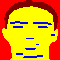

Learning rate:  0.00021600000000000002
Loss = tensor(1.3569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


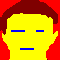

Learning rate:  0.00021600000000000002
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


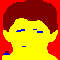

Learning rate:  0.00021600000000000002
Loss = tensor(1.3633, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


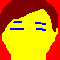

Learning rate:  0.00021600000000000002
Loss = tensor(1.3145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


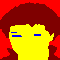

Learning rate:  0.00021600000000000002
Loss = tensor(1.3575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


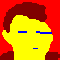

Learning rate:  0.00021600000000000002
Loss = tensor(1.3338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


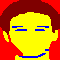

Learning rate:  0.00021600000000000002
Loss = tensor(1.3506, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


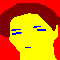

Learning rate:  0.00021600000000000002
Loss = tensor(1.3611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


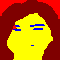

Learning rate:  0.00021600000000000002
Loss = tensor(1.3582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


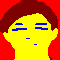

Learning rate:  0.00021600000000000002
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


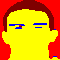

Learning rate:  0.00021600000000000002
Loss = tensor(1.3961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


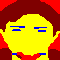

Learning rate:  0.00021600000000000002
Loss = tensor(1.3364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


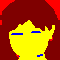

Learning rate:  0.00021600000000000002
Loss = tensor(1.3131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


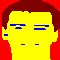

Learning rate:  0.00021600000000000002
Loss = tensor(1.3342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


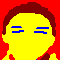

Learning rate:  0.00021600000000000002
Loss = tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


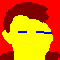

Learning rate:  0.00021600000000000002
Loss = tensor(1.3302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


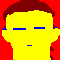

Learning rate:  0.00021600000000000002
Loss = tensor(1.3500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


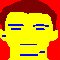

Learning rate:  0.00021600000000000002
Loss = tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


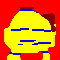

Learning rate:  0.00021600000000000002
Loss = tensor(1.3519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


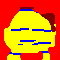

Learning rate:  0.00021600000000000002
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


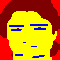

Learning rate:  0.00021600000000000002
Loss = tensor(1.3300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


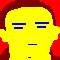

Learning rate:  0.00021600000000000002
Loss = tensor(1.3979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


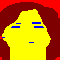

Learning rate:  0.00021600000000000002
Loss = tensor(1.3679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


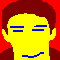

Learning rate:  0.00021600000000000002
Loss = tensor(1.3135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


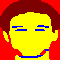

Learning rate:  0.00021600000000000002
Loss = tensor(1.3317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


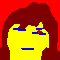

Learning rate:  0.00021600000000000002
Loss = tensor(1.3706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


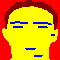

Learning rate:  0.00021600000000000002
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


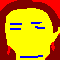

Learning rate:  0.00021600000000000002
Loss = tensor(1.3248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


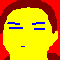

Learning rate:  0.00021600000000000002
Loss = tensor(1.3583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


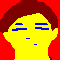

Learning rate:  0.00021600000000000002
Loss = tensor(1.3583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


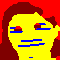

Learning rate:  0.00021600000000000002
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


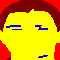

Learning rate:  0.00021600000000000002
Loss = tensor(1.3307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


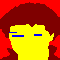

Learning rate:  0.00021600000000000002
Loss = tensor(1.3405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


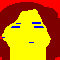

Learning rate:  0.00021600000000000002
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


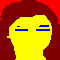

Learning rate:  0.00021600000000000002
Loss = tensor(1.3474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


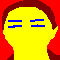

Learning rate:  0.00021600000000000002
Loss = tensor(1.3628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


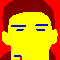

Learning rate:  0.00021600000000000002
Loss = tensor(1.3682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


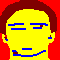

Learning rate:  0.00021600000000000002
Loss = tensor(1.3337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


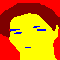

Learning rate:  0.00021600000000000002
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


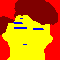

Learning rate:  0.00021600000000000002
Loss = tensor(1.3514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


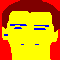

Learning rate:  0.0001296
Loss = tensor(1.3228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


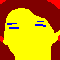

Learning rate:  0.0001296
Loss = tensor(1.3553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3499, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3679, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


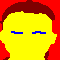

Learning rate:  0.0001296
Loss = tensor(1.3635, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


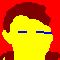

Learning rate:  0.0001296
Loss = tensor(1.3420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


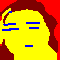

Learning rate:  0.0001296
Loss = tensor(1.3343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


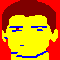

Learning rate:  0.0001296
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


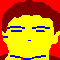

Learning rate:  0.0001296
Loss = tensor(1.3373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


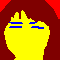

Learning rate:  0.0001296
Loss = tensor(1.3259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


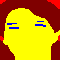

Learning rate:  0.0001296
Loss = tensor(1.3543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


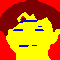

Learning rate:  0.0001296
Loss = tensor(1.3687, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


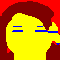

Learning rate:  0.0001296
Loss = tensor(1.3383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


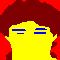

Learning rate:  0.0001296
Loss = tensor(1.3554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


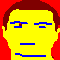

Learning rate:  0.0001296
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


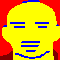

Learning rate:  0.0001296
Loss = tensor(1.3550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


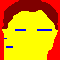

Learning rate:  0.0001296
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


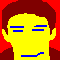

Learning rate:  0.0001296
Loss = tensor(1.3556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


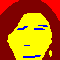

Learning rate:  0.0001296
Loss = tensor(1.3442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


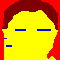

Learning rate:  0.0001296
Loss = tensor(1.3162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


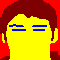

Learning rate:  0.0001296
Loss = tensor(1.3376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


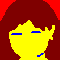

Learning rate:  0.0001296
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


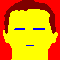

Learning rate:  0.0001296
Loss = tensor(1.3601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


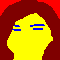

Learning rate:  0.0001296
Loss = tensor(1.3276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


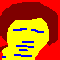

Learning rate:  0.0001296
Loss = tensor(1.3377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


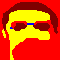

Learning rate:  0.0001296
Loss = tensor(1.3634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


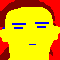

Learning rate:  0.0001296
Loss = tensor(1.3400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


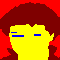

Learning rate:  0.0001296
Loss = tensor(1.3448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


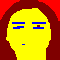

Learning rate:  0.0001296
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


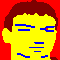

Learning rate:  0.0001296
Loss = tensor(1.3606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


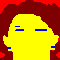

Learning rate:  0.0001296
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


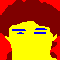

Learning rate:  0.0001296
Loss = tensor(1.3588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


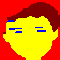

Learning rate:  0.0001296
Loss = tensor(1.3432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


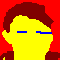

Learning rate:  0.0001296
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


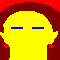

Learning rate:  0.0001296
Loss = tensor(1.3382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


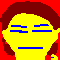

Learning rate:  0.0001296
Loss = tensor(1.3433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


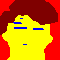

Learning rate:  0.0001296
Loss = tensor(1.3690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


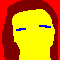

Learning rate:  0.0001296
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


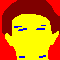

Learning rate:  0.0001296
Loss = tensor(1.3456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


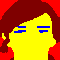

Learning rate:  0.0001296
Loss = tensor(1.3336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


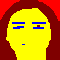

Learning rate:  0.0001296
Loss = tensor(1.3280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


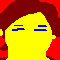

Learning rate:  0.0001296
Loss = tensor(1.3703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


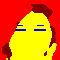

Learning rate:  0.0001296
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


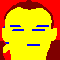

Learning rate:  0.0001296
Loss = tensor(1.3444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


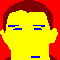

Learning rate:  0.0001296
Loss = tensor(1.3596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


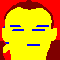

Learning rate:  0.0001296
Loss = tensor(1.3639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


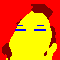

Learning rate:  0.0001296
Loss = tensor(1.3473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


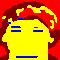

Learning rate:  0.0001296
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


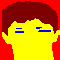

Learning rate:  0.0001296
Loss = tensor(1.3585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


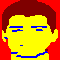

Learning rate:  0.0001296
Loss = tensor(1.3280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


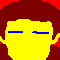

Learning rate:  0.0001296
Loss = tensor(1.3273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


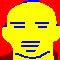

Learning rate:  0.0001296
Loss = tensor(1.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3490, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


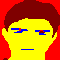

Learning rate:  0.0001296
Loss = tensor(1.3230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


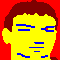

Learning rate:  0.0001296
Loss = tensor(1.3562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


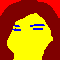

Learning rate:  0.0001296
Loss = tensor(1.3372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


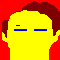

Learning rate:  0.0001296
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


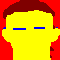

Learning rate:  0.0001296
Loss = tensor(1.3576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


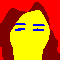

Learning rate:  0.0001296
Loss = tensor(1.3178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


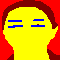

Learning rate:  0.0001296
Loss = tensor(1.3345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


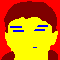

Learning rate:  0.0001296
Loss = tensor(1.3058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


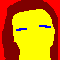

Learning rate:  0.0001296
Loss = tensor(1.3365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


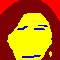

Learning rate:  0.0001296
Loss = tensor(1.3364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


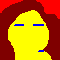

Learning rate:  0.0001296
Loss = tensor(1.3728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


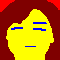

Learning rate:  0.0001296
Loss = tensor(1.3303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


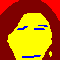

Learning rate:  0.0001296
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


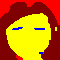

Learning rate:  0.0001296
Loss = tensor(1.3178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


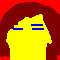

Learning rate:  0.0001296
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


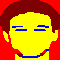

Learning rate:  0.0001296
Loss = tensor(1.3691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


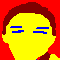

Learning rate:  0.0001296
Loss = tensor(1.3264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


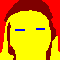

Learning rate:  0.0001296
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3694, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


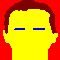

Learning rate:  0.0001296
Loss = tensor(1.3459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


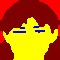

Learning rate:  0.0001296
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3336, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


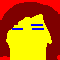

Learning rate:  0.0001296
Loss = tensor(1.3536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


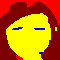

Learning rate:  0.0001296
Loss = tensor(1.3576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


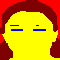

Learning rate:  0.0001296
Loss = tensor(1.3197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


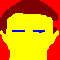

Learning rate:  0.0001296
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


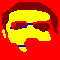

Learning rate:  0.0001296
Loss = tensor(1.3393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


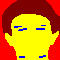

Learning rate:  0.0001296
Loss = tensor(1.3229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


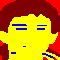

Learning rate:  0.0001296
Loss = tensor(1.3316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


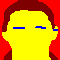

Learning rate:  0.0001296
Loss = tensor(1.3255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


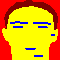

Learning rate:  0.0001296
Loss = tensor(1.3099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


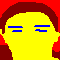

Learning rate:  0.0001296
Loss = tensor(1.3174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


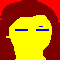

Learning rate:  0.0001296
Loss = tensor(1.3661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


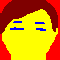

Learning rate:  0.0001296
Loss = tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3598, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


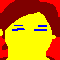

Learning rate:  0.0001296
Loss = tensor(1.3691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


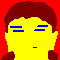

Learning rate:  0.0001296
Loss = tensor(1.3409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


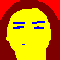

Learning rate:  0.0001296
Loss = tensor(1.3584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


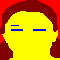

Learning rate:  0.0001296
Loss = tensor(1.3581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


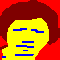

Learning rate:  0.0001296
Loss = tensor(1.3612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


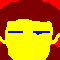

Learning rate:  0.0001296
Loss = tensor(1.3272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


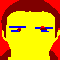

Learning rate:  0.0001296
Loss = tensor(1.3559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


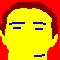

Learning rate:  0.0001296
Loss = tensor(1.3294, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


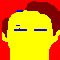

Learning rate:  7.776e-05
Loss = tensor(1.3643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


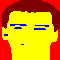

Learning rate:  7.776e-05
Loss = tensor(1.3174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


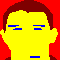

Learning rate:  7.776e-05
Loss = tensor(1.3246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


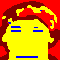

Learning rate:  7.776e-05
Loss = tensor(1.3464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


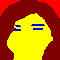

Learning rate:  7.776e-05
Loss = tensor(1.3229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


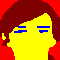

Learning rate:  7.776e-05
Loss = tensor(1.3648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


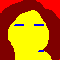

Learning rate:  7.776e-05
Loss = tensor(1.3048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


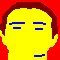

Learning rate:  7.776e-05
Loss = tensor(1.3475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


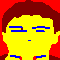

Learning rate:  7.776e-05
Loss = tensor(1.3486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


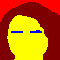

Learning rate:  7.776e-05
Loss = tensor(1.3448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


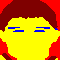

Learning rate:  7.776e-05
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


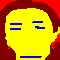

Learning rate:  7.776e-05
Loss = tensor(1.3426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


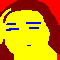

Learning rate:  7.776e-05
Loss = tensor(1.3469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


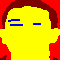

Learning rate:  7.776e-05
Loss = tensor(1.3275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


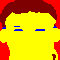

Learning rate:  7.776e-05
Loss = tensor(1.3196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


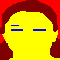

Learning rate:  7.776e-05
Loss = tensor(1.3246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


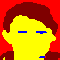

Learning rate:  7.776e-05
Loss = tensor(1.3380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3482, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


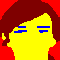

Learning rate:  7.776e-05
Loss = tensor(1.3656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3581, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


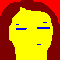

Learning rate:  7.776e-05
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


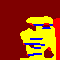

Learning rate:  7.776e-05
Loss = tensor(1.3376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


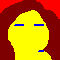

Learning rate:  7.776e-05
Loss = tensor(1.3502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


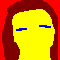

Learning rate:  7.776e-05
Loss = tensor(1.3253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


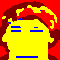

Learning rate:  7.776e-05
Loss = tensor(1.3432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


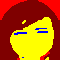

Learning rate:  7.776e-05
Loss = tensor(1.3191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


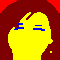

Learning rate:  7.776e-05
Loss = tensor(1.3691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


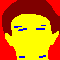

Learning rate:  7.776e-05
Loss = tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


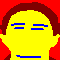

Learning rate:  7.776e-05
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


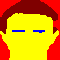

Learning rate:  7.776e-05
Loss = tensor(1.2979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


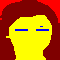

Learning rate:  7.776e-05
Loss = tensor(1.3634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


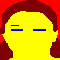

Learning rate:  7.776e-05
Loss = tensor(1.3564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


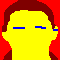

Learning rate:  7.776e-05
Loss = tensor(1.3605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


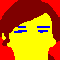

Learning rate:  7.776e-05
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


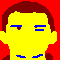

Learning rate:  7.776e-05
Loss = tensor(1.3034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


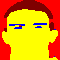

Learning rate:  7.776e-05
Loss = tensor(1.3307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


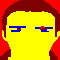

Learning rate:  7.776e-05
Loss = tensor(1.3424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


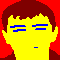

Learning rate:  7.776e-05
Loss = tensor(1.3136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


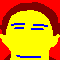

Learning rate:  7.776e-05
Loss = tensor(1.3119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


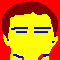

Learning rate:  7.776e-05
Loss = tensor(1.3035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


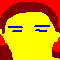

Learning rate:  7.776e-05
Loss = tensor(1.3535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


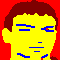

Learning rate:  7.776e-05
Loss = tensor(1.3129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


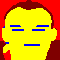

Learning rate:  7.776e-05
Loss = tensor(1.3179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


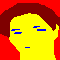

Learning rate:  7.776e-05
Loss = tensor(1.3587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3489, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


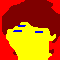

Learning rate:  7.776e-05
Loss = tensor(1.3732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


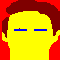

Learning rate:  7.776e-05
Loss = tensor(1.3680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


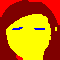

Learning rate:  7.776e-05
Loss = tensor(1.2962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


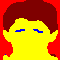

Learning rate:  7.776e-05
Loss = tensor(1.3638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


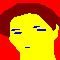

Learning rate:  7.776e-05
Loss = tensor(1.3012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


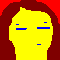

Learning rate:  7.776e-05
Loss = tensor(1.3220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


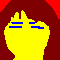

Learning rate:  7.776e-05
Loss = tensor(1.3384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


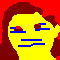

Learning rate:  7.776e-05
Loss = tensor(1.3323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


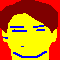

Learning rate:  7.776e-05
Loss = tensor(1.2991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


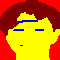

Learning rate:  7.776e-05
Loss = tensor(1.3324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


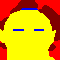

Learning rate:  7.776e-05
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


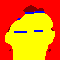

Learning rate:  7.776e-05
Loss = tensor(1.3804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


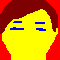

Learning rate:  7.776e-05
Loss = tensor(1.3382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


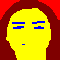

Learning rate:  7.776e-05
Loss = tensor(1.3464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


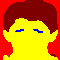

Learning rate:  7.776e-05
Loss = tensor(1.3328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


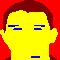

Learning rate:  7.776e-05
Loss = tensor(1.3263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


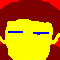

Learning rate:  7.776e-05
Loss = tensor(1.3390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


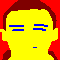

Learning rate:  7.776e-05
Loss = tensor(1.3565, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


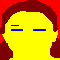

Learning rate:  7.776e-05
Loss = tensor(1.3283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


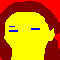

Learning rate:  7.776e-05
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


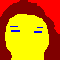

Learning rate:  7.776e-05
Loss = tensor(1.3146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


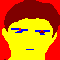

Learning rate:  7.776e-05
Loss = tensor(1.3528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3567, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


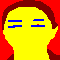

Learning rate:  7.776e-05
Loss = tensor(1.3296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


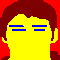

Learning rate:  7.776e-05
Loss = tensor(1.3330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


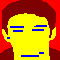

Learning rate:  7.776e-05
Loss = tensor(1.3177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


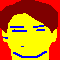

Learning rate:  7.776e-05
Loss = tensor(1.3714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


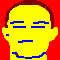

Learning rate:  7.776e-05
Loss = tensor(1.3008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


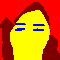

Learning rate:  7.776e-05
Loss = tensor(1.3552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


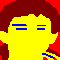

Learning rate:  7.776e-05
Loss = tensor(1.3369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


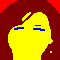

Learning rate:  7.776e-05
Loss = tensor(1.3365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


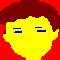

Learning rate:  7.776e-05
Loss = tensor(1.3393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


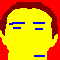

Learning rate:  7.776e-05
Loss = tensor(1.3311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


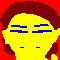

Learning rate:  7.776e-05
Loss = tensor(1.3046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


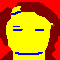

Learning rate:  7.776e-05
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


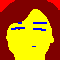

Learning rate:  7.776e-05
Loss = tensor(1.3595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


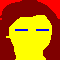

Learning rate:  7.776e-05
Loss = tensor(1.2985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


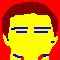

Learning rate:  7.776e-05
Loss = tensor(1.3400, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


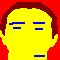

Learning rate:  7.776e-05
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


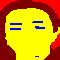

Learning rate:  7.776e-05
Loss = tensor(1.3417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


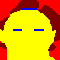

Learning rate:  7.776e-05
Loss = tensor(1.3316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


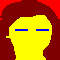

Learning rate:  7.776e-05
Loss = tensor(1.3471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


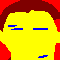

Learning rate:  7.776e-05
Loss = tensor(1.3785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


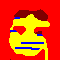

Learning rate:  7.776e-05
Loss = tensor(1.2915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3599, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


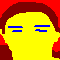

Learning rate:  7.776e-05
Loss = tensor(1.3426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3338, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


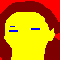

Learning rate:  7.776e-05
Loss = tensor(1.3032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


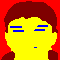

Learning rate:  7.776e-05
Loss = tensor(1.3211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3541, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


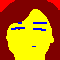

Learning rate:  7.776e-05
Loss = tensor(1.3050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


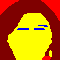

Learning rate:  7.776e-05
Loss = tensor(1.3389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


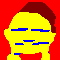

Learning rate:  7.776e-05
Loss = tensor(1.3147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3623, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


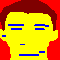

Learning rate:  7.776e-05
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


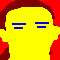

Learning rate:  7.776e-05
Loss = tensor(1.3242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


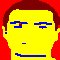

Learning rate:  7.776e-05
Loss = tensor(1.3323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


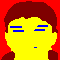

Learning rate:  7.776e-05
Loss = tensor(1.3899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


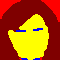

Learning rate:  7.776e-05
Loss = tensor(1.3363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


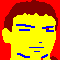

Learning rate:  7.776e-05
Loss = tensor(1.3773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


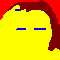

Learning rate:  7.776e-05
Loss = tensor(1.3447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


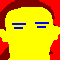

Learning rate:  7.776e-05
Loss = tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


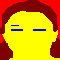

Learning rate:  7.776e-05
Loss = tensor(1.3205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


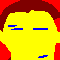

Learning rate:  7.776e-05
Loss = tensor(1.3615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


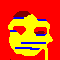

Learning rate:  7.776e-05
Loss = tensor(1.3377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


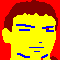

Learning rate:  7.776e-05
Loss = tensor(1.3186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


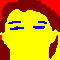

Learning rate:  7.776e-05
Loss = tensor(1.3518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3134, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


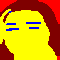

Learning rate:  7.776e-05
Loss = tensor(1.3374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


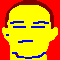

Learning rate:  7.776e-05
Loss = tensor(1.3423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


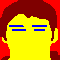

Learning rate:  7.776e-05
Loss = tensor(1.2944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


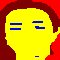

Learning rate:  7.776e-05
Loss = tensor(1.3249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


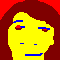

Learning rate:  7.776e-05
Loss = tensor(1.3558, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


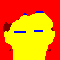

Learning rate:  7.776e-05
Loss = tensor(1.3542, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


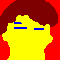

Learning rate:  7.776e-05
Loss = tensor(1.3373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


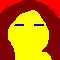

Learning rate:  7.776e-05
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


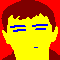

Learning rate:  7.776e-05
Loss = tensor(1.3569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


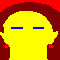

Learning rate:  7.776e-05
Loss = tensor(1.3721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


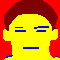

Learning rate:  7.776e-05
Loss = tensor(1.3607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


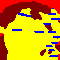

Learning rate:  7.776e-05
Loss = tensor(1.3077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3127, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


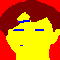

Learning rate:  7.776e-05
Loss = tensor(1.3714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


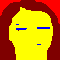

Learning rate:  7.776e-05
Loss = tensor(1.3138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


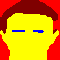

Learning rate:  7.776e-05
Loss = tensor(1.3716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


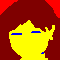

Learning rate:  7.776e-05
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


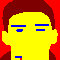

Learning rate:  7.776e-05
Loss = tensor(1.3669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


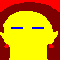

Learning rate:  7.776e-05
Loss = tensor(1.3058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


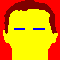

Learning rate:  7.776e-05
Loss = tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3637, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


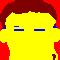

Learning rate:  7.776e-05
Loss = tensor(1.3167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3375, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


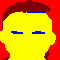

Learning rate:  7.776e-05
Loss = tensor(1.3643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3165, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


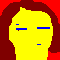

Learning rate:  7.776e-05
Loss = tensor(1.3383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


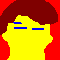

Learning rate:  7.776e-05
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


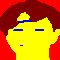

Learning rate:  7.776e-05
Loss = tensor(1.3779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


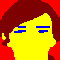

Learning rate:  7.776e-05
Loss = tensor(1.3173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


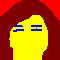

Learning rate:  7.776e-05
Loss = tensor(1.3149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


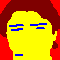

Learning rate:  7.776e-05
Loss = tensor(1.3357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3315, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


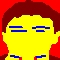

Learning rate:  7.776e-05
Loss = tensor(1.3530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


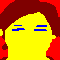

Learning rate:  7.776e-05
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


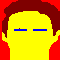

Learning rate:  7.776e-05
Loss = tensor(1.3549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


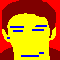

Learning rate:  7.776e-05
Loss = tensor(1.3534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


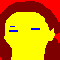

Learning rate:  7.776e-05
Loss = tensor(1.3221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


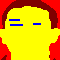

Learning rate:  7.776e-05
Loss = tensor(1.3433, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


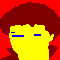

Learning rate:  7.776e-05
Loss = tensor(1.3868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


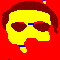

Learning rate:  7.776e-05
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


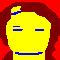

Learning rate:  7.776e-05
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


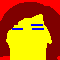

Learning rate:  7.776e-05
Loss = tensor(1.3205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


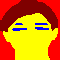

Learning rate:  7.776e-05
Loss = tensor(1.3301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3713, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


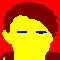

Learning rate:  7.776e-05
Loss = tensor(1.3335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


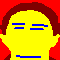

Learning rate:  7.776e-05
Loss = tensor(1.3422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


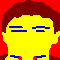

Learning rate:  7.776e-05
Loss = tensor(1.3807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


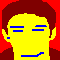

Learning rate:  7.776e-05
Loss = tensor(1.3526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3438, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


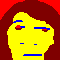

Learning rate:  7.776e-05
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


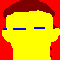

Learning rate:  7.776e-05
Loss = tensor(1.3421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


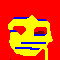

Learning rate:  7.776e-05
Loss = tensor(1.3092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


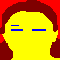

Learning rate:  7.776e-05
Loss = tensor(1.3249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3316, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


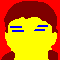

Learning rate:  7.776e-05
Loss = tensor(1.3383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


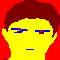

Learning rate:  7.776e-05
Loss = tensor(1.3837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


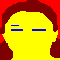

Learning rate:  7.776e-05
Loss = tensor(1.3220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


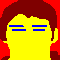

Learning rate:  7.776e-05
Loss = tensor(1.3366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


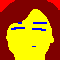

Learning rate:  7.776e-05
Loss = tensor(1.3754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


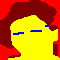

Learning rate:  7.776e-05
Loss = tensor(1.3415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


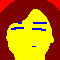

Learning rate:  7.776e-05
Loss = tensor(1.3611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


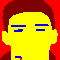

Learning rate:  7.776e-05
Loss = tensor(1.3421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


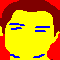

Learning rate:  7.776e-05
Loss = tensor(1.3171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


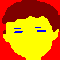

Learning rate:  7.776e-05
Loss = tensor(1.3353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


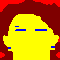

Learning rate:  7.776e-05
Loss = tensor(1.3395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3532, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


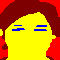

Learning rate:  7.776e-05
Loss = tensor(1.3243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


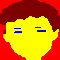

Learning rate:  7.776e-05
Loss = tensor(1.3763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


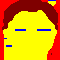

Learning rate:  7.776e-05
Loss = tensor(1.3283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


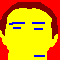

Learning rate:  7.776e-05
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


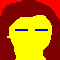

Learning rate:  7.776e-05
Loss = tensor(1.3283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


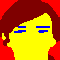

Learning rate:  7.776e-05
Loss = tensor(1.3366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


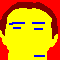

Learning rate:  7.776e-05
Loss = tensor(1.3098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


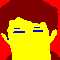

Learning rate:  7.776e-05
Loss = tensor(1.3680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


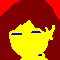

Learning rate:  7.776e-05
Loss = tensor(1.3273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


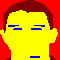

Learning rate:  7.776e-05
Loss = tensor(1.3364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


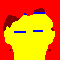

Learning rate:  7.776e-05
Loss = tensor(1.3224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


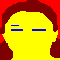

Learning rate:  7.776e-05
Loss = tensor(1.3639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


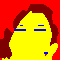

Learning rate:  7.776e-05
Loss = tensor(1.3305, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


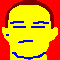

Learning rate:  7.776e-05
Loss = tensor(1.3225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


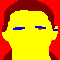

Learning rate:  7.776e-05
Loss = tensor(1.3496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


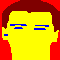

Learning rate:  7.776e-05
Loss = tensor(1.3259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


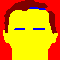

Learning rate:  7.776e-05
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


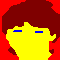

Learning rate:  7.776e-05
Loss = tensor(1.3075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


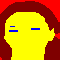

Learning rate:  7.776e-05
Loss = tensor(1.3640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


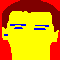

Learning rate:  7.776e-05
Loss = tensor(1.3233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3515, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


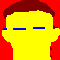

Learning rate:  7.776e-05
Loss = tensor(1.3138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3618, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


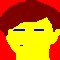

Learning rate:  7.776e-05
Loss = tensor(1.3267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


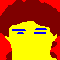

Learning rate:  7.776e-05
Loss = tensor(1.3135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


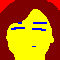

Learning rate:  7.776e-05
Loss = tensor(1.3646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


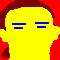

Learning rate:  7.776e-05
Loss = tensor(1.3309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


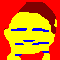

Learning rate:  7.776e-05
Loss = tensor(1.3386, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


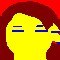

Learning rate:  7.776e-05
Loss = tensor(1.3115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


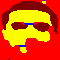

Learning rate:  7.776e-05
Loss = tensor(1.3473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


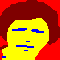

Learning rate:  7.776e-05
Loss = tensor(1.3246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


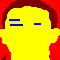

Learning rate:  7.776e-05
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


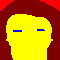

Learning rate:  7.776e-05
Loss = tensor(1.3341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


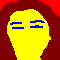

Learning rate:  7.776e-05
Loss = tensor(1.3411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3522, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3353, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


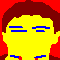

Learning rate:  7.776e-05
Loss = tensor(1.3133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


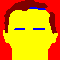

Learning rate:  7.776e-05
Loss = tensor(1.3166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


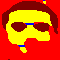

Learning rate:  7.776e-05
Loss = tensor(1.3206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3026, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


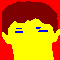

Learning rate:  7.776e-05
Loss = tensor(1.3131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


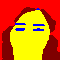

Learning rate:  7.776e-05
Loss = tensor(1.2870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3537, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


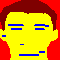

Learning rate:  7.776e-05
Loss = tensor(1.3478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


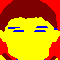

Learning rate:  7.776e-05
Loss = tensor(1.3151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3366, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3402, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


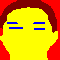

Learning rate:  7.776e-05
Loss = tensor(1.3587, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


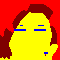

Learning rate:  7.776e-05
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


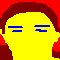

Learning rate:  7.776e-05
Loss = tensor(1.3100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


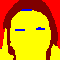

Learning rate:  7.776e-05
Loss = tensor(1.3079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


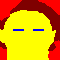

Learning rate:  7.776e-05
Loss = tensor(1.3265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3428, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


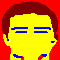

Learning rate:  7.776e-05
Loss = tensor(1.3247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3486, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


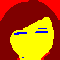

Learning rate:  7.776e-05
Loss = tensor(1.3096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


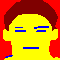

Learning rate:  7.776e-05
Loss = tensor(1.3416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


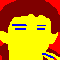

Learning rate:  7.776e-05
Loss = tensor(1.3476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


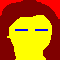

Learning rate:  7.776e-05
Loss = tensor(1.3300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


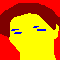

Learning rate:  7.776e-05
Loss = tensor(1.3217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


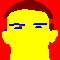

Learning rate:  7.776e-05
Loss = tensor(1.2898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


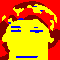

Learning rate:  7.776e-05
Loss = tensor(1.3122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


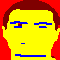

Learning rate:  7.776e-05
Loss = tensor(1.3277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


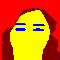

Learning rate:  7.776e-05
Loss = tensor(1.3025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


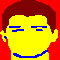

Learning rate:  7.776e-05
Loss = tensor(1.3528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


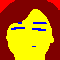

Learning rate:  7.776e-05
Loss = tensor(1.3051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


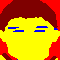

Learning rate:  7.776e-05
Loss = tensor(1.3130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3577, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


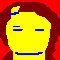

Learning rate:  7.776e-05
Loss = tensor(1.3297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


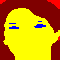

Learning rate:  7.776e-05
Loss = tensor(1.3704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


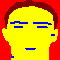

Learning rate:  7.776e-05
Loss = tensor(1.3028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3253, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


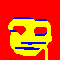

Learning rate:  7.776e-05
Loss = tensor(1.3210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


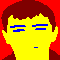

Learning rate:  7.776e-05
Loss = tensor(1.3566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


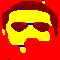

Learning rate:  7.776e-05
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


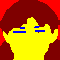

Learning rate:  7.776e-05
Loss = tensor(1.2899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


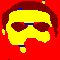

Learning rate:  7.776e-05
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


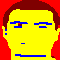

Learning rate:  7.776e-05
Loss = tensor(1.3314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3447, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


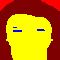

Learning rate:  7.776e-05
Loss = tensor(1.3242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


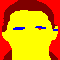

Learning rate:  7.776e-05
Loss = tensor(1.3082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


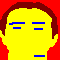

Learning rate:  7.776e-05
Loss = tensor(1.3529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3352, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


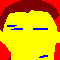

Learning rate:  7.776e-05
Loss = tensor(1.3248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


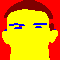

Learning rate:  7.776e-05
Loss = tensor(1.2987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


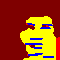

Learning rate:  7.776e-05
Loss = tensor(1.3405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


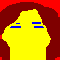

Learning rate:  7.776e-05
Loss = tensor(1.3358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


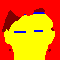

Learning rate:  7.776e-05
Loss = tensor(1.3365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3347, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


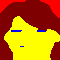

Learning rate:  7.776e-05
Loss = tensor(1.3343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


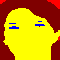

Learning rate:  7.776e-05
Loss = tensor(1.3480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


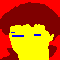

Learning rate:  7.776e-05
Loss = tensor(1.3337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


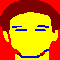

Learning rate:  7.776e-05
Loss = tensor(1.3125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3628, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


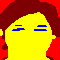

Learning rate:  7.776e-05
Loss = tensor(1.3287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


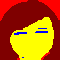

Learning rate:  7.776e-05
Loss = tensor(1.3278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


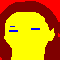

Learning rate:  7.776e-05
Loss = tensor(1.3221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


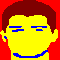

Learning rate:  7.776e-05
Loss = tensor(1.3039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


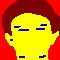

Learning rate:  7.776e-05
Loss = tensor(1.3916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3255, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


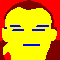

Learning rate:  7.776e-05
Loss = tensor(1.3019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


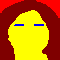

Learning rate:  7.776e-05
Loss = tensor(1.3736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


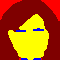

Learning rate:  7.776e-05
Loss = tensor(1.3540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3272, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


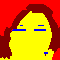

Learning rate:  7.776e-05
Loss = tensor(1.3252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


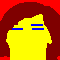

Learning rate:  7.776e-05
Loss = tensor(1.3159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


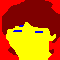

Learning rate:  7.776e-05
Loss = tensor(1.3225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


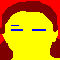

Learning rate:  7.776e-05
Loss = tensor(1.3358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


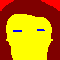

Learning rate:  7.776e-05
Loss = tensor(1.3156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


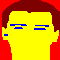

Learning rate:  7.776e-05
Loss = tensor(1.3349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


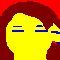

Learning rate:  7.776e-05
Loss = tensor(1.3656, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


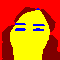

Learning rate:  7.776e-05
Loss = tensor(1.3394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


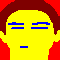

Learning rate:  7.776e-05
Loss = tensor(1.3437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


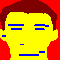

Learning rate:  7.776e-05
Loss = tensor(1.3619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


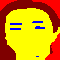

Learning rate:  7.776e-05
Loss = tensor(1.3002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


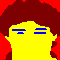

Learning rate:  7.776e-05
Loss = tensor(1.3175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


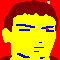

Learning rate:  7.776e-05
Loss = tensor(1.3398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3617, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


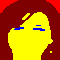

Learning rate:  7.776e-05
Loss = tensor(1.3239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


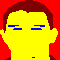

Learning rate:  7.776e-05
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3267, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


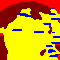

Learning rate:  7.776e-05
Loss = tensor(1.3445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


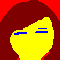

Learning rate:  7.776e-05
Loss = tensor(1.3322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


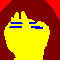

Learning rate:  7.776e-05
Loss = tensor(1.3289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


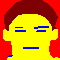

Learning rate:  7.776e-05
Loss = tensor(1.3389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


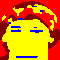

Learning rate:  7.776e-05
Loss = tensor(1.3004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


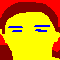

Learning rate:  7.776e-05
Loss = tensor(1.3215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


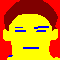

Learning rate:  7.776e-05
Loss = tensor(1.3320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


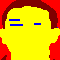

Learning rate:  7.776e-05
Loss = tensor(1.3340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3292, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


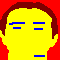

Learning rate:  7.776e-05
Loss = tensor(1.3086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


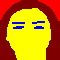

Learning rate:  7.776e-05
Loss = tensor(1.3308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


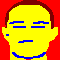

Learning rate:  7.776e-05
Loss = tensor(1.3180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


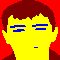

Learning rate:  7.776e-05
Loss = tensor(1.3922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3306, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


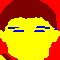

Learning rate:  7.776e-05
Loss = tensor(1.3857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


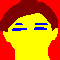

Learning rate:  7.776e-05
Loss = tensor(1.3394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


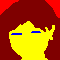

Learning rate:  7.776e-05
Loss = tensor(1.3544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


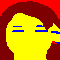

Learning rate:  7.776e-05
Loss = tensor(1.3154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


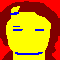

Learning rate:  7.776e-05
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


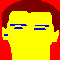

Learning rate:  7.776e-05
Loss = tensor(1.3455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


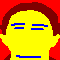

Learning rate:  7.776e-05
Loss = tensor(1.3601, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


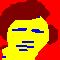

Learning rate:  7.776e-05
Loss = tensor(1.3113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


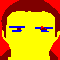

Learning rate:  7.776e-05
Loss = tensor(1.3140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3501, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3217, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


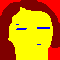

Learning rate:  7.776e-05
Loss = tensor(1.3417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3330, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


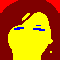

Learning rate:  7.776e-05
Loss = tensor(1.3388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


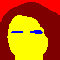

Learning rate:  7.776e-05
Loss = tensor(1.3368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


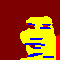

Learning rate:  7.776e-05
Loss = tensor(1.3051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


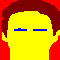

Learning rate:  7.776e-05
Loss = tensor(1.3214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


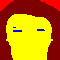

Learning rate:  7.776e-05
Loss = tensor(1.3174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


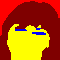

Learning rate:  7.776e-05
Loss = tensor(1.3268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3165, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3384, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


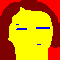

Learning rate:  7.776e-05
Loss = tensor(1.3744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4100, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


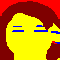

Learning rate:  7.776e-05
Loss = tensor(1.3237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


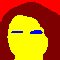

Learning rate:  7.776e-05
Loss = tensor(1.2952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


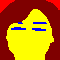

Learning rate:  7.776e-05
Loss = tensor(1.3511, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


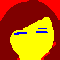

Learning rate:  7.776e-05
Loss = tensor(1.3418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3290, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


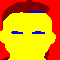

Learning rate:  7.776e-05
Loss = tensor(1.3576, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


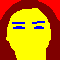

Learning rate:  7.776e-05
Loss = tensor(1.3619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


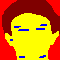

Learning rate:  7.776e-05
Loss = tensor(1.3378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3611, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


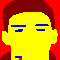

Learning rate:  7.776e-05
Loss = tensor(1.3307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3496, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


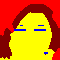

Learning rate:  7.776e-05
Loss = tensor(1.3563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


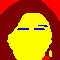

Learning rate:  7.776e-05
Loss = tensor(1.3404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3301, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


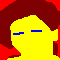

Learning rate:  7.776e-05
Loss = tensor(1.3417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3145, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


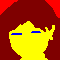

Learning rate:  7.776e-05
Loss = tensor(1.3107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


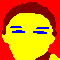

Learning rate:  7.776e-05
Loss = tensor(1.3222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


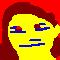

Learning rate:  7.776e-05
Loss = tensor(1.3158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


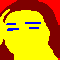

Learning rate:  7.776e-05
Loss = tensor(1.3460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


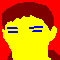

Learning rate:  7.776e-05
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


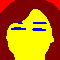

Learning rate:  7.776e-05
Loss = tensor(1.3354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


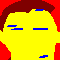

Learning rate:  7.776e-05
Loss = tensor(1.3455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


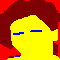

Learning rate:  7.776e-05
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3339, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


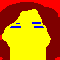

Learning rate:  7.776e-05
Loss = tensor(1.3518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


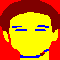

Learning rate:  7.776e-05
Loss = tensor(1.3406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


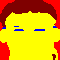

Learning rate:  7.776e-05
Loss = tensor(1.3392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


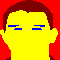

Learning rate:  7.776e-05
Loss = tensor(1.3327, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3367, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


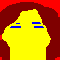

Learning rate:  7.776e-05
Loss = tensor(1.3133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


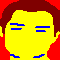

Learning rate:  7.776e-05
Loss = tensor(1.3271, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3103, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


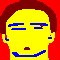

Learning rate:  7.776e-05
Loss = tensor(1.3114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3194, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


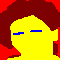

Learning rate:  7.776e-05
Loss = tensor(1.3112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


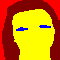

Learning rate:  7.776e-05
Loss = tensor(1.3479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


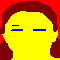

Learning rate:  7.776e-05
Loss = tensor(1.3186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3571, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


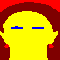

Learning rate:  7.776e-05
Loss = tensor(1.3328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


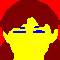

Learning rate:  7.776e-05
Loss = tensor(1.3444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3331, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


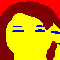

Learning rate:  7.776e-05
Loss = tensor(1.3477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.2988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3212, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


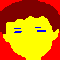

Learning rate:  7.776e-05
Loss = tensor(1.3872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


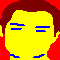

Learning rate:  7.776e-05
Loss = tensor(1.3180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


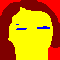

Learning rate:  7.776e-05
Loss = tensor(1.3211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3465, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


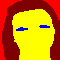

Learning rate:  7.776e-05
Loss = tensor(1.3328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


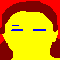

Learning rate:  7.776e-05
Loss = tensor(1.3488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


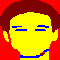

Learning rate:  7.776e-05
Loss = tensor(1.3403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


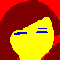

Learning rate:  7.776e-05
Loss = tensor(1.3307, device='cuda:0', grad_fn=<NllLoss2DBackward>)


In [13]:
# Cross-entropy training loop
for epoch in range(epochs):
    i = 0
    # Last is so we can record the steps from the final epoch
    last = False
    if epoch == epochs:
        last = True
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        #out = loss1(b,c) + 4*loss1(b[3],c[3])+15*loss1(b[4],c[4])+4*loss1(b[5],c[5])
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
    scheduler.step()

In [14]:
torch.save(model, 'misc_figures/naive.pth')

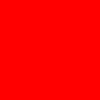

In [26]:
from IPython.display import display, Image
Image('final.gif')

In [ ]:
plt.plot(loss_mse)

In [31]:
torch.argmax(get_rgb(x), dim=1).flatten(1,2).shape

torch.Size([5, 4900])

torch.Size([60, 60, 4])


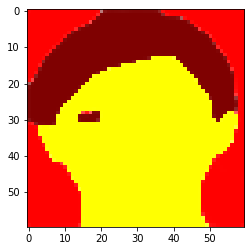

In [28]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [39]:
# Save final iterations as gif

epoch_new = [ts(i) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

def dice(pred, truth, epsilon=1e-6):
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)
    
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    d5 = 2*TP+FN+FP
    if d5 == 0:
        d5 = epsilon
    dice = 2*TP/d5
    
    return dice  

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [13]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.6257, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


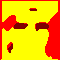

1.6256805658340454
Loss = tensor(1.2909, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


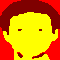

1.2909468412399292
Loss = tensor(1.3848, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


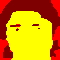

1.3847682476043701
Loss = tensor(1.3942, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


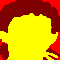

1.394240140914917
Loss = tensor(1.2760, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


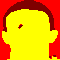

1.275985836982727
Loss = tensor(1.3382, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


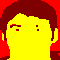

1.338197946548462
Loss = tensor(1.3876, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


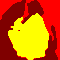

1.3876286745071411
Loss = tensor(1.3286, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


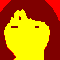

1.3285850286483765
Loss = tensor(1.3165, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


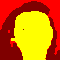

1.3164860010147095
Loss = tensor(1.3535, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


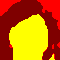

1.3534773588180542
Loss = tensor(1.2847, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


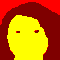

1.284747838973999
Loss = tensor(1.2992, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


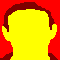

1.2991952896118164
Loss = tensor(1.4886, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


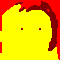

1.488637089729309
Loss = tensor(1.2852, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


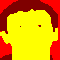

1.2851858139038086
Loss = tensor(1.3334, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


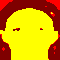

1.3333861827850342
Loss = tensor(1.2625, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


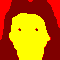

1.2625274658203125
Loss = tensor(1.3842, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


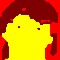

1.3842464685440063
Loss = tensor(1.2911, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


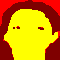

1.2910785675048828
Loss = tensor(1.4117, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


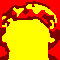

1.4116612672805786
Loss = tensor(1.3177, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


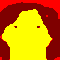

1.317700982093811
Loss = tensor(1.2965, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


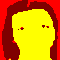

1.2964756488800049
Loss = tensor(1.3595, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


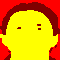

1.3594715595245361
Loss = tensor(1.3431, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


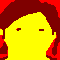

1.3431376218795776
Loss = tensor(1.3827, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


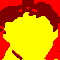

1.3826584815979004
Loss = tensor(1.3589, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


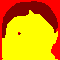

1.358903169631958
Loss = tensor(1.4311, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


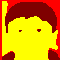

1.431139349937439
Loss = tensor(1.2611, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


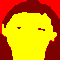

1.26105797290802
Loss = tensor(1.3772, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


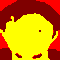

1.377220630645752
Loss = tensor(1.3926, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


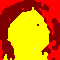

1.392622709274292
Loss = tensor(1.4908, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


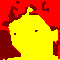

1.490848183631897


In [14]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [16]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/naive_p.npy', boxplot_p)
np.save('metrics/naive_r.npy', boxplot_r)
np.save('metrics/naive_a.npy', boxplot_a)
np.save('metrics/naive_s.npy', boxplot_s)
np.save('metrics/naive_m.npy', boxplot_mi)
np.save('metrics/naive_dice.npy', dice_list)

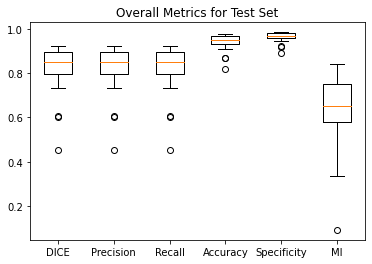

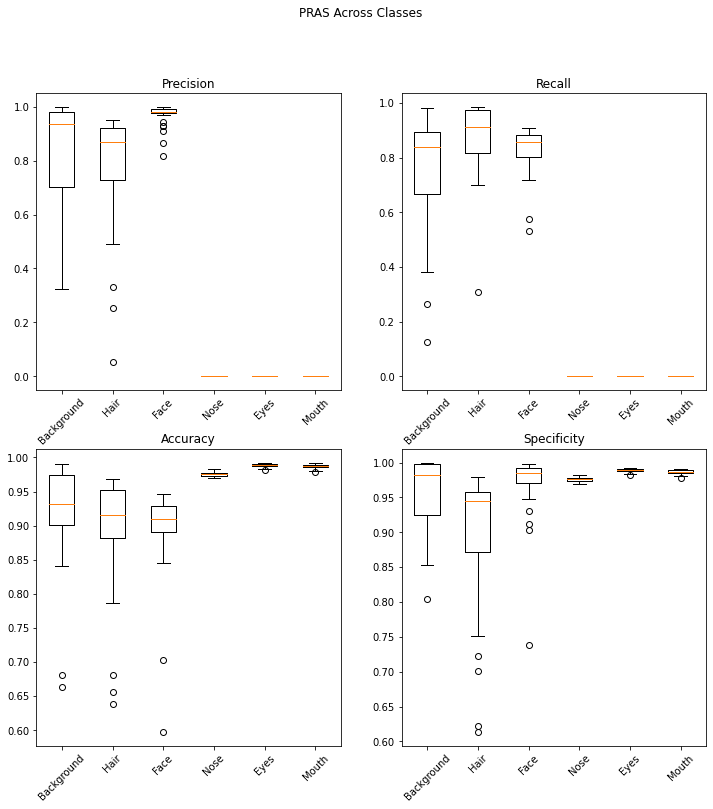

In [17]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1NaivePras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("1NaivePrasClass.png")

In [22]:
np.save('1dice_naive.npy', np.array(dice_list))

In [21]:
# Analysing stability using number of steps
last = False
stability_dice = []
images = []
batch_size = 1


for i in range(1,50):
    dice_list=[]
    with torch.no_grad():
        for batch in test_loader_CE:
            inputs, targets = batch
            if last == True:
                x, epoch_history = model.forward(i*10, inputs, last=last)
            else:
                x = model.forward(i*10, inputs, last=last)

            b = get_rgb(x)
            pred = torch.argmax(b, dim=1)
            out = loss2(b, targets.detach().long())
            c = b.detach().clone()
            images.append(c)
        
            target = targets.detach().long()
        
            d = dice(pred, target)
            dice_list.append(d.item())
                
            
        print("Steps: " + str(10*i) + " " + str(np.mean(dice_list)))
        stability_dice.append(np.mean(dice_list))
    

Steps: 10 0.7817777777777778
Steps: 20 0.797861111111111
Steps: 30 0.807185185185185
Steps: 40 0.813111111111111
Steps: 50 0.8173148148148148
Steps: 60 0.8200833333333333
Steps: 70 0.8221666666666667
Steps: 80 0.8239166666666666
Steps: 90 0.8246759259259259
Steps: 100 0.8249537037037036
Steps: 110 0.8254444444444444
Steps: 120 0.8258425925925927
Steps: 130 0.8262314814814816
Steps: 140 0.8264907407407409
Steps: 150 0.826648148148148
Steps: 160 0.8268796296296297
Steps: 170 0.8270833333333333
Steps: 180 0.8273611111111112
Steps: 190 0.8274814814814814
Steps: 200 0.8275185185185183
Steps: 210 0.8276296296296296
Steps: 220 0.8277500000000001
Steps: 230 0.8278148148148147
Steps: 240 0.8277685185185184
Steps: 250 0.8277222222222221
Steps: 260 0.8277407407407408
Steps: 270 0.8277962962962963
Steps: 280 0.8278611111111108
Steps: 290 0.827824074074074
Steps: 300 0.8277592592592591
Steps: 310 0.8277777777777778
Steps: 320 0.8278055555555555
Steps: 330 0.8278611111111112
Steps: 340 0.82782407407

In [14]:
# Save the DICE scores for the stability plot
np.save('metrics/stability_naive.npy', stability_dice)